In [1]:
# Important necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

from matplotlib import rc
rc('text', usetex=True)
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=25)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=25)

%matplotlib inline  

# Reading the Data

In [22]:
def readfile(name, folder='ntuples_2_6/', lumi=3.2*1000):
    data = pd.read_csv(folder+name+'.evt', header=0, delimiter=',', skipinitialspace=True)
    data.meta = pd.read_csv(folder+name+'.meta', header=0, delimiter=',', skipinitialspace=True)
    if 'weight' in data.columns:
        data['weight'] *= (data.meta['cxn']*lumi/data.meta['sum_weight'])[0]
    else:
        data['weight'] = (data.meta['cxn']*lumi / data.meta['nevt'])[0]  
    return data

bkg = ['bkg_ttbar_semilep', 'bkg_ttbar_dilep', 'bkg_Wj', 'bkg_Zj']
bkg = [ readfile(f) for f in bkg ]


    
rinv = [.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, .98, 1.0 ]

def to_str(num):
    if num <= .9:
        return '{:.1g}'.format(num)
    elif num!= 1:
        return '{:.2g}'.format(num)
    else:
        return '1.0'

rinv_str = [  to_str(r)  for r in rinv ]
rinv_str = [ 'monojet_rinv' + st for st in rinv_str ]


sig = [ readfile(f, 'ntuples/') for f in rinv_str ]
np.sum(bkg[-1]['weight'])

73899.25111319037

### Let's make some quick plots

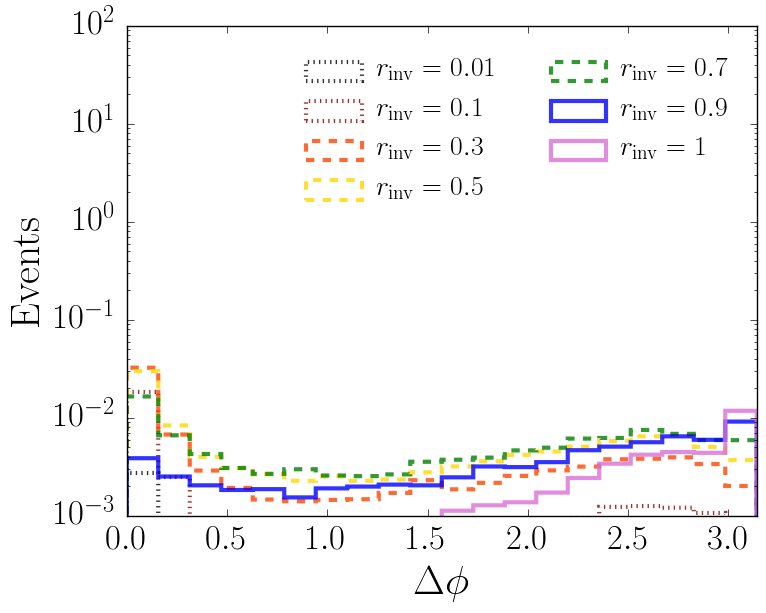

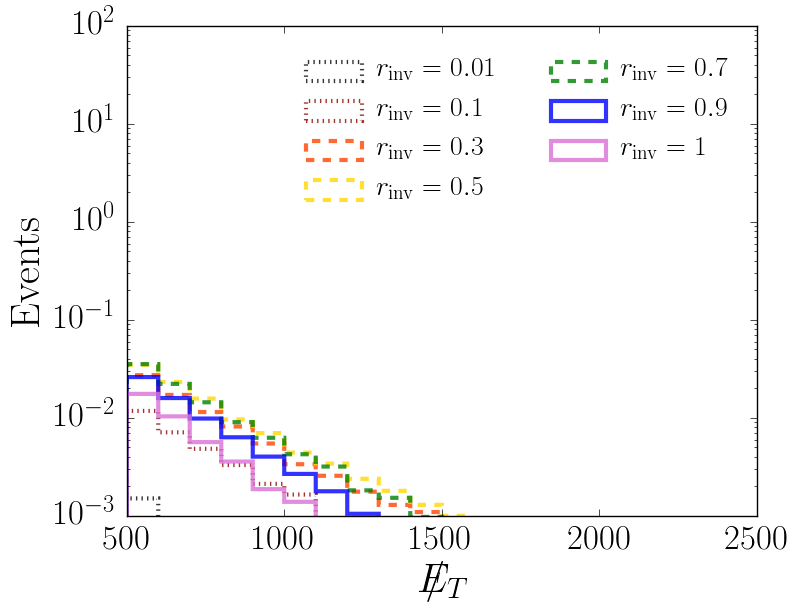

In [23]:
# make histograms
def newfig(name):
    fig=plt.figure(name,figsize=(9,7))
    plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)


plot_color=[ 'black', 'darkred', 'red', 'orangered', 'orange', 'gold', 'yellowgreen', 
            'green', 'darkcyan', 'blue', 'mediumpurple','orchid', 'hotpink','purple']

plot_ls=['dotted','dotted','dotted',
         'dashed','dashed','dashed','dashed',
        'dashed','solid','solid','solid','solid']

def plot_dphi(l):
    newfig("dphi")
    for i,fb in enumerate(sig):
        if rinv[i] in l:
            f=fb.query('pt1 > 250 & MEt > 100')
            mylabel=("$r_{\\rm inv}=%0.1g$" % rinv[i])
            if rinv[i] > 0.9:
                mylabel="$r_{\\rm inv}=%0.2g$" % rinv[i]

            plt.hist(f['dphi'], weights=f['weight'], 
                     bins=np.linspace(0,np.pi,20 + 1),
                     histtype='step', color=plot_color[i], alpha=.8, lw=3, linestyle=plot_ls[i],
                     label=mylabel)
            plt.xlim([0,np.pi])
            plt.yscale('log', nonposy='clip')
            plt.xlabel(r'$\Delta \phi$',fontsize=30)
            plt.ylabel(r'${\rm Events}$',fontsize=30)



def plot_met(l):
    newfig("met")
    for i,fb in enumerate(sig):
        if rinv[i] in l:
            f=fb.query('pt1 > 250 & MEt > 100')
            mylabel=("$r_{\\rm inv}=%0.1g$" % rinv[i])
            if rinv[i] > 0.9:
                mylabel="$r_{\\rm inv}=%0.2g$" % rinv[i]

            plt.hist(f['MEt'], weights=f['weight'], 
                     bins=np.linspace(500,2500,20 + 1),
                     histtype='step', color=plot_color[i], alpha=.8, lw=3, linestyle=plot_ls[i],
                     label=mylabel)
            plt.xlim([500,2500])
            plt.yscale('log', nonposy='clip')
            plt.xlabel(r'$\slash \!\!\!\! E_{T}$',fontsize=30)
            plt.ylabel(r'${\rm Events}$',fontsize=30)


            
plot_dphi(l=[.01, .1, .3, .5, .7, .9,1.0])
plt.ylim([1e-3, 100])
plt.legend(bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=20, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

plt.savefig('dphi_sig.pdf')
plt.show()


plot_met(l=[.01, .1, .3, .5, .7, .9, 1.0])
plt.ylim([1e-3, 100])
plt.legend(bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=20, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)


#plt.xscale('log', nonposy='clip')
#ticks=10.0**(np.arange(-3,3,1))

plt.savefig('met_sig.pdf')
plt.show()


In [24]:
def plot_dphi(l):
    newfig("dphi_bkg")
    for i,fb in enumerate(bkg):
        f=fb.query('pt1 > 250 & MEt > 100')
        mylabel=("$r_{\\rm inv}=%0.1g$" % rinv[i])
        if rinv[i] > 0.9:
            mylabel="$r_{\\rm inv}=%0.2g$" % rinv[i]

        plt.hist(f['dphi'], weights=f['weight'], 
                 bins=np.linspace(0,np.pi,20 + 1),
                 histtype='step', color=plot_color[i], alpha=.8, lw=3, linestyle=plot_ls[i],
                 label=mylabel)
        plt.xlim([0,np.pi])
        plt.yscale('log', nonposy='clip')
        plt.xlabel(r'$\Delta \phi$',fontsize=30)
        plt.ylabel(r'${\rm Events}$',fontsize=30)



In [25]:
def get_exclusion(extra_cut='dphi > 0.4 ', sys_factor=1.0):
    metcut = [ 700, 800, 900, 1000, 1100, 1200 ]
    sys = [0.04, 0.0475, 0.055, 0.0625, 0.07, 0.095]
    sys = [ s*sys_factor for s in sys ]

    cut = [ 'MEt > ' + str(mc) + ' & pt1 > 300' + '& ' + extra_cut for mc in metcut]
    nevt_cut = np.asarray([ [ np.sum(d.query(c)['weight']) for d in sig ] for c in cut ])

    exclusion_bkg = np.asarray([ [np.sum(d.query(c)['weight']) for d in bkg ] for c in cut])

    sum_bkg = np.sum(exclusion_bkg, axis=1)
    exclusion=2*np.sqrt(sum_bkg + (sum_bkg*sys)**2)
    exclusion_factor = np.asarray([ exclusion[i]/c for i,c in enumerate(nevt_cut) ])

    return np.amin(exclusion_factor, axis=0)

exc_small= get_exclusion(extra_cut='dphi < 0.4 ', sys_factor=3.0)
exc_large= get_exclusion(extra_cut='dphi > 0.4 ')


print(np.asarray([np.sum(d.query('dphi>0.4 & 600 > MEt > 500 & pt1 > 250')['weight']) for d in bkg]))
print(exc_small)
print(exc_large)

[   9.59005363    0.          206.88486135  372.13599237]
[  9137.15767145   1278.90876152    771.60982545    613.94864184
    545.64922801    564.0967036     707.40947232    859.34932409
   1373.18364158   3346.81610402  22208.52217363  31245.63000742]
[ 32020.10712847   4529.13013485   1888.47767224   1339.09712402
   1052.36644349    862.72383216    784.36291952    776.9044494
    839.46144596   1052.09718723   1643.09795527   1940.19593647]


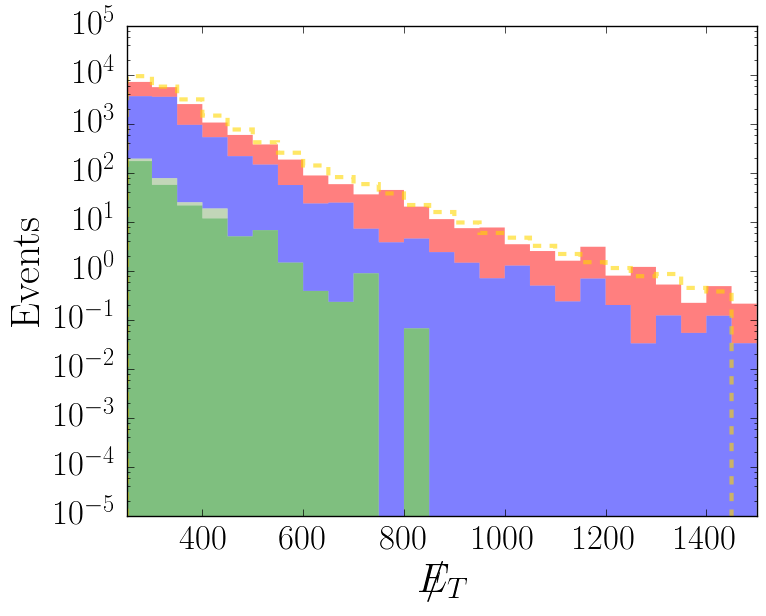

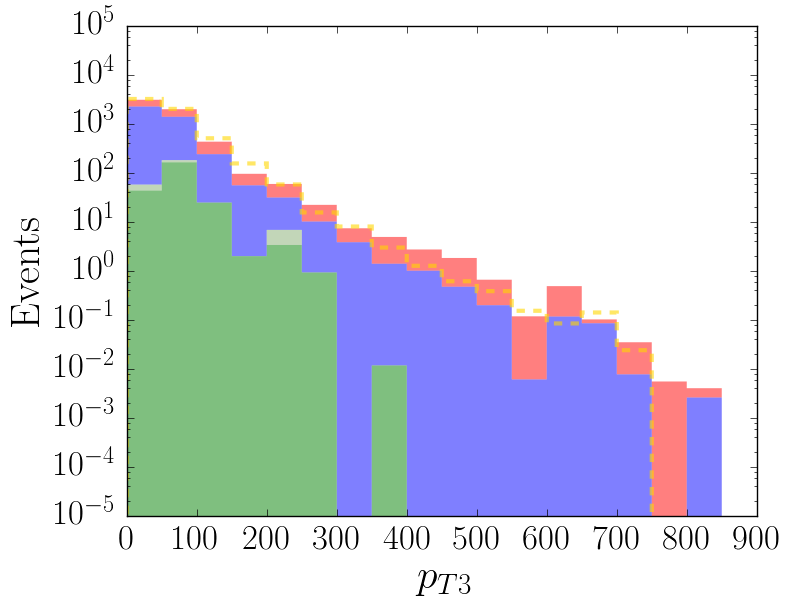

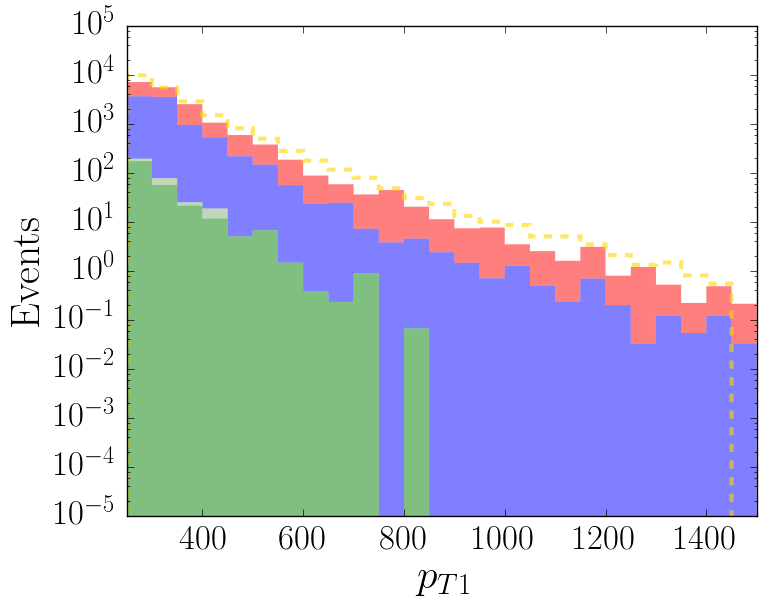

In [26]:
pt3_valid = pd.read_csv('ntuples/pt3_validation.csv', header=0, delimiter=',', skipinitialspace=True)
pt1_valid = pd.read_csv('ntuples/pt1_validation.csv', header=0, delimiter=',', skipinitialspace=True)
met_valid = pd.read_csv('ntuples/MET_validation.csv', header=0, delimiter=',', skipinitialspace=True)


bkg_cut = [ b.query('pt1>250 & MEt>250 & eta1<2.4 & nj<=4 & dphi >.4') for b in bkg ]
color_list= ['green','sage', 'blue','red']


newfig('met')
hist_list= [ b['MEt'] for b in bkg_cut ]
w_list= [ b['weight'] for b in bkg_cut ]
plt.hist(hist_list, weights=w_list,
         bins=np.linspace(0,1500,1500/50 + 1),
         histtype='stepfilled', stacked=True, color=color_list, alpha=.5, lw=0,
         label=[r'$t\bar{t}\rightarrow 2l+j$',r'$t\bar{t}\rightarrow l+j$',r'$W+j$',r'$W+j$',r'$Z+j$'])

plt.hist(met_valid['MEt'],weights=met_valid['nevt'],bins=np.linspace(0,1500,1500/50 + 1),histtype='step', lw=3, alpha=.6, color='gold', ls='--')

plt.xlim([250,1500])
plt.ylim([1e-5,1e5])
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\slash \!\!\!\! E_{T}$',fontsize=30)
plt.ylabel(r'${\rm Events}$',fontsize=30)
plt.savefig('met.pdf')

newfig('pt3')
hist_list= [ b['pt3'] for b in bkg_cut ]
w_list= [ b['weight'] for b in bkg_cut ]
plt.hist(hist_list, weights=w_list,
         bins=np.linspace(0,2000,2000/50 + 1),
         histtype='stepfilled', stacked=True, color=color_list, alpha=.5, lw=0,
         label=[r'$W+j$',r'$Z+j$'])

plt.hist(pt3_valid['pt3'],weights=pt3_valid['nevt'],bins=np.linspace(0,2000,2000/50 + 1),histtype='step', lw=3, alpha=.6, color='gold', ls='--')

plt.xlim([0,900])
plt.ylim([1e-5,1e5])
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$p_{T3}$',fontsize=30)
plt.ylabel(r'${\rm Events}$',fontsize=30)
plt.savefig('pt3.pdf')


newfig('pt1')
hist_list= [ b['MEt'] for b in bkg_cut ]
w_list= [ b['weight'] for b in bkg_cut ]
plt.hist(hist_list, weights=w_list,
         bins=np.linspace(0,1500,1500/50 + 1),
         histtype='stepfilled', stacked=True, color=color_list, alpha=.5, lw=0,
         label=[r'$W+j$',r'$Z+j$'])

plt.hist(pt1_valid['pt1'],weights=pt1_valid['nevt'],bins=np.linspace(0,1500,1500/50 + 1),histtype='step', lw=3, alpha=.6, color='gold', ls='--')


plt.xlim([250,1500])
plt.ylim([1e-5,1e5])
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$p_{T1}$',fontsize=30)
plt.ylabel(r'${\rm Events}$',fontsize=30)
plt.savefig('pt1.pdf')


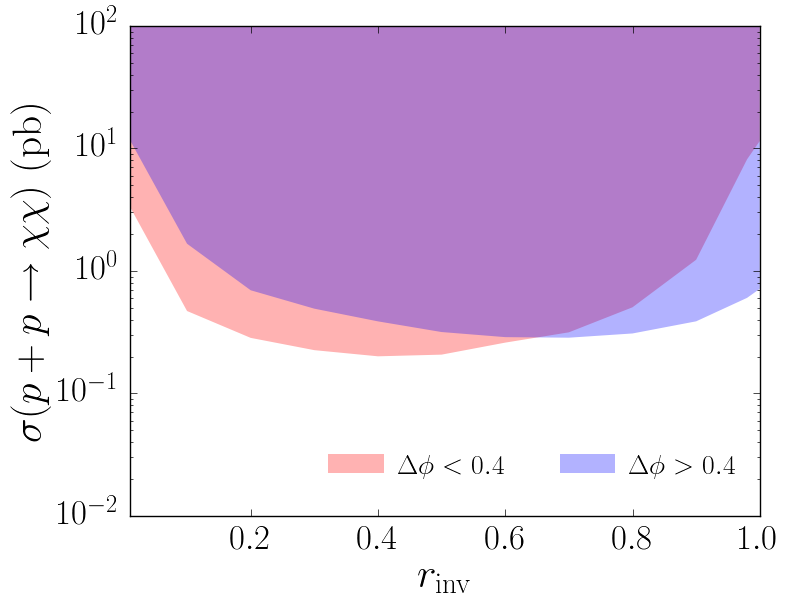

In [27]:
newfig("exc")
#plt.plot(rinv, np.sqrt(exc/(5./2.)**4), lw=3, alpha=0.3)



# plot excluded cxn
cxn=np.asarray([ d.meta['cxn'][0] for d in sig ])

plt.fill_between(rinv, exc_small*cxn, 1e8, lw=0, 
                 color='red', facecolor='red',alpha=0.3, label=r'$\Delta \phi < 0.4$')
plt.fill_between(rinv, exc_large*cxn, 1e8, lw=0,
                 color='blue', facecolor='blue',alpha=0.3, label=r'$\Delta \phi > 0.4$')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=30)
plt.ylabel(r'$\sigma(p + p \rightarrow \chi \chi) \;({\rm pb})$',fontsize=30)
plt.xlim([0.01,1.0])
plt.ylim([1e-2, 1e2])
plt.savefig("cxn.pdf")

plt.legend(bbox_to_anchor=(0, 0, 0.98, 0.15),
           fontsize=20, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)


plt.show()


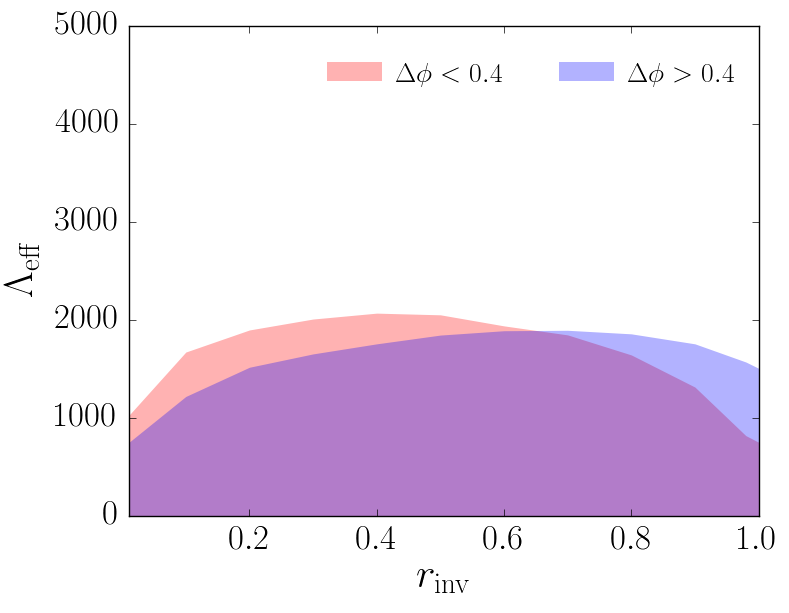

In [28]:
newfig("cutoff")
#plt.plot(rinv, np.sqrt(exc/(5./2.)**4), lw=3, alpha=0.3)



# plot excluded cxn
cxn=np.asarray([ d.meta['cxn'][0] for d in sig ])

cutoff=10000
plt.fill_between(rinv, 0, cutoff/(exc_small**(1/4)), lw=0, 
                 color='red', facecolor='red',alpha=0.3, label=r'$\Delta \phi < 0.4$')
plt.fill_between(rinv, 0, cutoff/(exc_large**(1/4)), lw=0,
                 color='blue', facecolor='blue',alpha=0.3, label=r'$\Delta \phi > 0.4$')
#plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=30)
plt.ylabel(r'$\Lambda_{\rm eff}$',fontsize=30)
plt.xlim([0.01,1.0])
plt.ylim([0, 5000])
plt.savefig("cxn.pdf")

plt.legend(bbox_to_anchor=(0, 0, 0.98, 0.95),
           fontsize=20, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)


plt.show()
